## Random Forest

In [19]:
import pandas as pd

# Cargar el archivo de eventos válidos
eventos_df = pd.read_csv("eventos_validos.csv")

# Definir las posibles clases
tipos_evento = ["1 Stiker Slip (SS)", "2 Normal-Oblique", "3 Reverse-Oblique"]
magnitudes = ["Mag. 4-6", "Mag. 6-8"]
vs30_clases = ["Vs30. 0-200", "Vs30. 200-400", "Vs30. 400-600", "Vs30. 600-"]

# Crear un DataFrame vacío para los labels
labels = pd.DataFrame()

# Crear columnas para cada etiqueta
for tipo in tipos_evento:
    labels[tipo] = (eventos_df["Tipo de evento"] == tipo).astype(int)

for mag in magnitudes:
    labels[mag] = (eventos_df["Magnitud"] == mag).astype(int)

for vs in vs30_clases:
    labels[vs] = (eventos_df["Vs30"] == vs).astype(int)

# Guardar el archivo de labels
labels.to_csv("labels_eventos.csv", index=False)

print("✅ Archivo labels_eventos.csv creado correctamente.")


✅ Archivo labels_eventos.csv creado correctamente.


In [20]:
import pandas as pd

# Cargar features y labels
features = pd.read_csv('features_fft_eventos.csv')  # header=None si los datos no tienen nombre de columnas
labels = pd.read_csv('labels_eventos.csv')  # Aquí asumo que labels sí tiene encabezados (tipo_evento, magnitud, vs30, etc.)

# Verificar tamaños
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Importante: verificar que el número de filas coincida
if features.shape[0] != labels.shape[0]:
    raise ValueError("El número de filas entre features y labels no coincide")

# Concatenar features y labels
dataset = pd.concat([features, labels], axis=1)

# Guardar dataset combinado
dataset.to_csv('dataset_completo.csv', index=False)

print("Dataset combinado guardado como 'dataset_completo.csv'")
print(dataset.columns)



Features shape: (1696, 771)
Labels shape: (1696, 9)
Dataset combinado guardado como 'dataset_completo.csv'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '770', '1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique',
       'Mag. 4-6', 'Mag. 6-8', 'Vs30. 0-200', 'Vs30. 200-400', 'Vs30. 400-600',
       'Vs30. 600-'],
      dtype='object', length=780)


In [21]:
import pandas as pd

# Cargar dataset
dataset = pd.read_csv('dataset_completo.csv')

# Definir columnas de etiquetas
label_columns = [
    '1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique',
    'Mag. 4-6', 'Mag. 6-8',
    'Vs30. 0-200', 'Vs30. 200-400', 'Vs30. 400-600', 'Vs30. 600-'
]

# Crear columna combinada
dataset['combined_labels'] = dataset[label_columns].apply(lambda x: '_'.join(map(str, x)), axis=1)

# Separar features y target combinado
X = dataset.drop(columns=label_columns + ['combined_labels'])
y = dataset['combined_labels']

# Contar combinaciones
conteo = y.value_counts()

# Mantener solo combinaciones que aparecen >=6 veces
combinaciones_validas = conteo[conteo >= 6].index

# Filtrar dataset
dataset_filtrado = dataset[dataset['combined_labels'].isin(combinaciones_validas)]

# 👉🏻 Desde aquí es donde cambiamos el flujo:

# --- NUEVO OVERSAMPLING MANUAL ---
objetivo_por_clase = 50  # Por ejemplo, queremos mínimo 50 ejemplos por clase

# Lista para los nuevos datos
nuevos_datos = []

# Agrupar y balancear
for combinacion in combinaciones_validas:
    datos_clase = dataset_filtrado[dataset_filtrado['combined_labels'] == combinacion]
    cantidad_actual = len(datos_clase)

    if cantidad_actual < objetivo_por_clase:
        # Calculamos cuántas veces repetir
        veces_repetir = objetivo_por_clase // cantidad_actual
        resto = objetivo_por_clase % cantidad_actual

        # Repetimos datos
        datos_repetidos = pd.concat([datos_clase] * veces_repetir, ignore_index=True)

        # Agregamos algunos extras si hace falta
        if resto > 0:
            datos_repetidos = pd.concat([datos_repetidos, datos_clase.sample(n=resto, replace=True)], ignore_index=True)

        nuevos_datos.append(datos_repetidos)
    else:
        nuevos_datos.append(datos_clase)

# Unir todo
dataset_balanceado = pd.concat(nuevos_datos, ignore_index=True)

# Volver a separar etiquetas
split_labels = dataset_balanceado['combined_labels'].str.split('_', expand=True).astype(int)
split_labels.columns = label_columns

# Eliminar columna combinada Y las etiquetas anteriores
dataset_balanceado = dataset_balanceado.drop(columns=label_columns + ['combined_labels']).join(split_labels)

# Guardar
dataset_balanceado.to_csv('dataset_balanceado_final.csv', index=False)

print("✅ Dataset balanceado correctamente y guardado como 'dataset_balanceado_final.csv'")


✅ Dataset balanceado correctamente y guardado como 'dataset_balanceado_final.csv'


In [22]:
import pandas as pd

# Si tienes un archivo CSV
df = pd.read_csv('dataset_balanceado_final.csv')

# Separar X (características)
X = df.iloc[:, 0:771]  # Columnas de la 0 a la 770

# Crear una nueva columna 'Clase' basada en cuál de las 3 está activa
def determinar_clase(fila):
    if fila['1 Stiker Slip (SS)'] == 1:
        return 'Sticker Slip'
    elif fila['2 Normal-Oblique'] == 1:
        return 'Strike Oblicuo'
    elif fila['3 Reverse-Oblique'] == 1:
        return 'Reverse Oblicuo'
    else:
        return 'Otro'

df['Clase'] = df.apply(determinar_clase, axis=1)

# Preparar X e y para RandomForest
X = df[[str(i) for i in range(0, 771)]]  # las columnas '0' a '770'
y = df['Clase']

# Verificar que cada fila tenga una sola etiqueta activa
multilabel_error = df[['1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique']].sum(axis=1) != 1

print(f"Número de filas con múltiples etiquetas activas: {multilabel_error.sum()}")

# Limpiar si es necesario
df = df[~multilabel_error]

# Crear columna de Clase
df['Clase'] = df.apply(determinar_clase, axis=1)

X = df[[str(i) for i in range(0, 771)]]
y = df['Clase']

print(df[['1 Stiker Slip (SS)', '2 Normal-Oblique', '3 Reverse-Oblique']].sum())

Número de filas con múltiples etiquetas activas: 0
1 Stiker Slip (SS)    620
2 Normal-Oblique      501
3 Reverse-Oblique     707
dtype: int64


In [23]:
print(X.shape)
print(y.value_counts())
print(X.isnull().sum().sum())  # Verifica si hay valores NaN

(1828, 771)
Clase
Reverse Oblicuo    707
Sticker Slip       620
Strike Oblicuo     501
Name: count, dtype: int64
0


Accuracy: 0.60

Matriz de Confusión:
[[99 42 15]
 [28 80  3]
 [36 21 42]]

Reporte de Clasificación:
                 precision    recall  f1-score   support

Reverse Oblicuo       0.61      0.63      0.62       156
   Sticker Slip       0.56      0.72      0.63       111
 Strike Oblicuo       0.70      0.42      0.53        99

       accuracy                           0.60       366
      macro avg       0.62      0.59      0.59       366
   weighted avg       0.62      0.60      0.60       366

Features: 10 - Accuracy: 0.6038
Features: 20 - Accuracy: 0.6148
Features: 30 - Accuracy: 0.6175
Features: 40 - Accuracy: 0.6230
Features: 50 - Accuracy: 0.5902
Features: 70 - Accuracy: 0.6066
Features: 100 - Accuracy: 0.6202


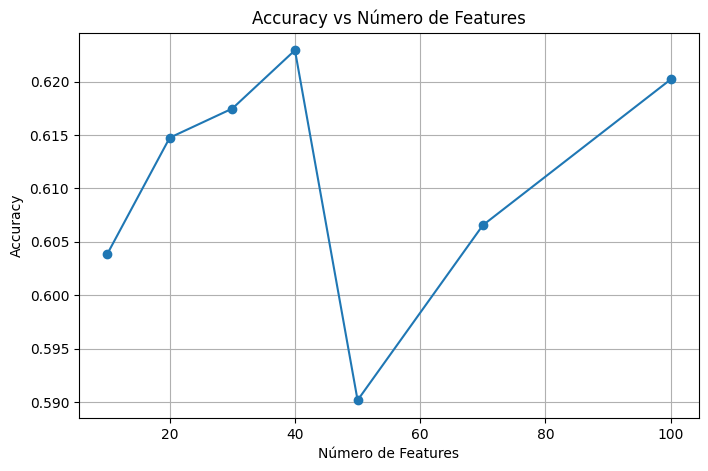

Random Forest F1_micro: 0.5613 (+/- 0.0193)


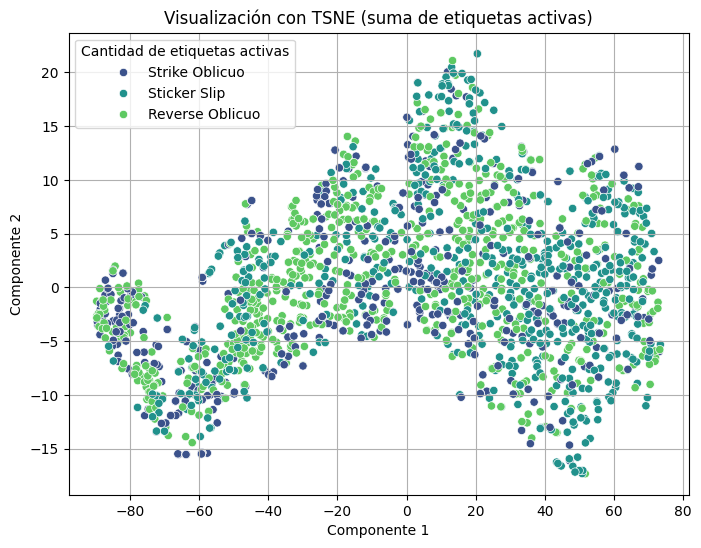

Mejores parámetros encontrados para Random Forest: {'clf__estimator__max_depth': 10, 'clf__estimator__max_features': 0.5, 'clf__estimator__min_samples_leaf': 5, 'clf__estimator__n_estimators': 100}


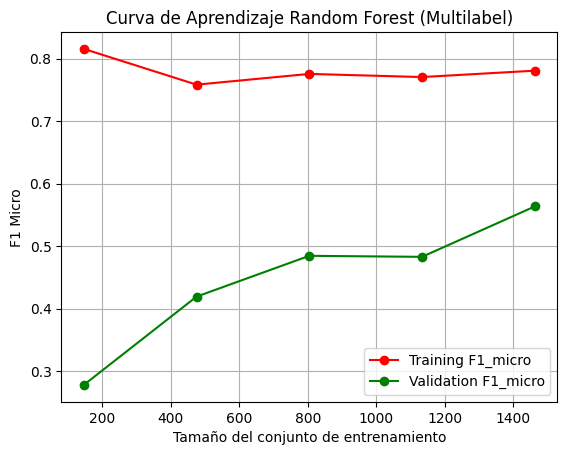

In [24]:
## Proyecto: Random Forest desde features procesados

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.manifold import TSNE

from scipy.stats import ttest_rel

# ------------------------------------
# 1. Cargar datos procesados (features)
# ------------------------------------

X = pd.read_csv('features_top100.csv')
# Asegurarse que Y esté correctamente cargado
# y = ... (aquí deberías cargar tus etiquetas)

# ------------------------------------
# 2. Random Forest Simple
# ------------------------------------

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Random Forest
modelo = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
modelo.fit(X_train, y_train)

# Predicción
y_pred = modelo.predict(X_test)

# Evaluación
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# ------------------------------------
# 3. Evaluar accuracy con diferentes número de features
# ------------------------------------

importancias = modelo.feature_importances_
indices_importantes = np.argsort(importancias)[::-1]

valores_k = [10, 20, 30, 40, 50, 70, 100]
accuracies = []

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for k in valores_k:
    selected_features = indices_importantes[:k]
    X_train = X_train_full.iloc[:, selected_features]
    X_test = X_test_full.iloc[:, selected_features]
    
    modelo_k = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
    modelo_k.fit(X_train, y_train)
    y_pred = modelo_k.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Resultados
for k, acc in zip(valores_k, accuracies):
    print(f"Features: {k} - Accuracy: {acc:.4f}")

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(valores_k, accuracies, marker='o')
plt.title('Accuracy vs Número de Features')
plt.xlabel('Número de Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# ------------------------------------
# 4. Random Forest Multietiqueta con Pipeline
# ------------------------------------

pipeline_rf = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=70)),
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=15,
        max_features='sqrt',
        random_state=42
    )))
])

# Cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

scores_rf = cross_val_score(pipeline_rf, X, y, cv=rkf, scoring='f1_micro')
print(f'Random Forest F1_micro: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})')

# ------------------------------------
# 5. Visualización t-SNE
# ------------------------------------

X_reduced = SelectKBest(score_func=f_classif, k=50).fit_transform(X, y)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis')
plt.title('Visualización con TSNE (suma de etiquetas activas)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Cantidad de etiquetas activas')
plt.grid(True)
plt.show()

# ------------------------------------
# 6. Optimización de hiperparámetros
# ------------------------------------

param_grid = {
    'clf__estimator__n_estimators': [100],
    'clf__estimator__max_depth': [5, 8, 10],
    'clf__estimator__min_samples_leaf': [5, 10, 15, 20],
    'clf__estimator__max_features': ['sqrt', 0.5, 0.7]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid, cv=rkf, scoring='f1_micro', n_jobs=-1)
grid_search_rf.fit(X, y)

print(f"Mejores parámetros encontrados para Random Forest: {grid_search_rf.best_params_}")

# ------------------------------------
# 7. Curva de aprendizaje
# ------------------------------------

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_rf, X, y, cv=rkf, n_jobs=-1, scoring='f1_micro', 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1_micro")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation F1_micro")
plt.title('Curva de Aprendizaje Random Forest (Multilabel)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1 Micro')
plt.legend(loc="best")
plt.grid()
plt.show()


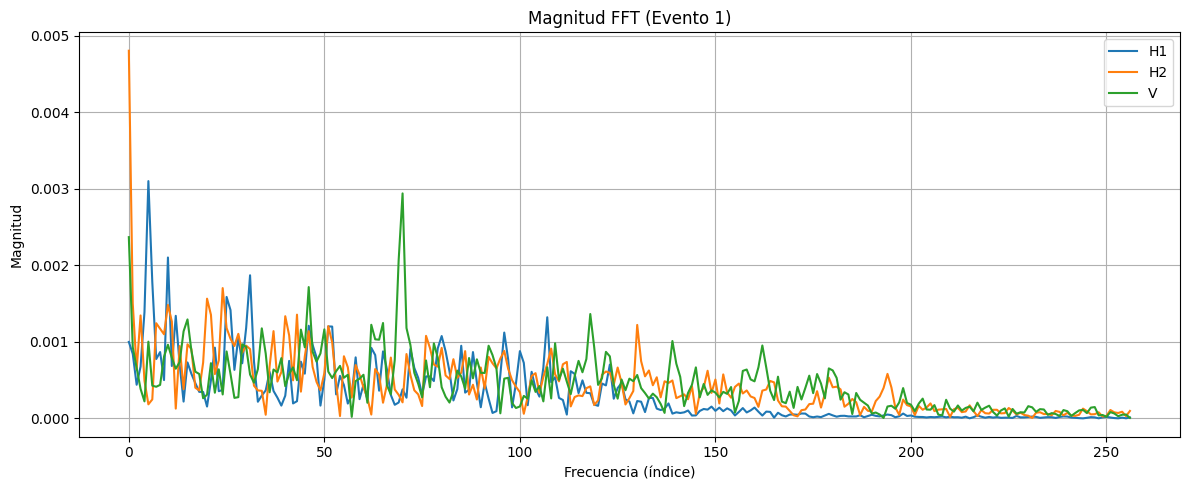

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar las características
X = pd.read_csv("features_fft_eventos.csv")

# Obtener el evento 1 (primera fila)
evento_1 = X.iloc[1690].values

# Asumimos que tienes 3 componentes (H1, H2, V) y FFT de 256+1 puntos por cada uno
fft_len = 512 // 2 + 1  # 257
componentes = ['H1', 'H2', 'V']

# Cortar el vector para separar las 3 componentes
h1 = evento_1[:fft_len]
h2 = evento_1[fft_len:2*fft_len]
v  = evento_1[2*fft_len:]

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(h1, label="H1")
plt.plot(h2, label="H2")
plt.plot(v, label="V")
plt.title("Magnitud FFT (Evento 1)")
plt.xlabel("Frecuencia (índice)")
plt.ylabel("Magnitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()